In [1]:
# !pip install numpy
# !pip install scipy
# !pip install torch
# !pip install matplotlib
#!pip install scikit-learn

In [2]:
import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [3]:
gpu = torch.device("cuda:0")
print(torch.cuda.get_device_name(0))


# Use smaller network for testing - ex 2000 neurons
# Even for the project, doing it for 10^6 neurons would take too long
# Problem this creates: test network is denser than actual network b/c we have 10^3 neurons but 10^2 connections per neuron
num_neurons = 2000
num_i = int(0.1 * num_neurons)
num_e = int(0.9 * num_neurons)

# Epsilon value close to 0 to prevent nan in division by 0
eps = 1e-6

# Num excitatory inputs and inhibitory inputs to each neuron (in reality it should be 500 but we reduce it here to make things faster)
k = 100

# Number of olfactory bulb channels (glomeruli) to each neuron
D = 10 ** 3
# For each neuron, how many glomeruli inputs it receives (should be 10^2)
num_channel_inputs = 100

# Number of odors
P = 16
# Novel activity is up to P // 2, and familiar activity is after
novel_inds = torch.arange(0, P // 2)
familiar_inds = torch.arange(P // 2, P)

NVIDIA GeForce RTX 3060


In [4]:
# Creates sparse adjacency matrix with the given probability of edge connection and size mxn
def create_adj_matrix(p, m, n):
    # num_connections = int(p * m * n)
    # m_coords = torch.randint(0, m, (num_connections,))
    # n_coords = torch.randint(0, n, (num_connections,))
    # indices = torch.vstack((m_coords, n_coords))
    # values = torch.ones(num_connections)
    # A_mn = torch.sparse_coo_tensor(indices, values, (m, n))
    probs = torch.ones(m, n) * p
    A_mn = torch.bernoulli(probs)
    return A_mn

In [5]:
# New way of generating correlations between odors: we want different sets of odors to be correlated differently, so that when we subtract each neuron's mean activity over odors, it doesn't cancel out the variation between odors (if all the odors are correlated the same, they will tend to produce similar values for a single neuron and therefore subtracting by the mean will remove these values and only leave small fluctuations)
# So we sample a small set of odors P' and make them linearly independent, and then by multiplying by a P'x P gaussian matrix we project into mitral cell activity space for all P odors, basically making the P odors a linear combination of the set of P' odors (the smaller P' is, the more correlated the resulting set of P odors will be)
# We also scale the variance depending on how small P' is, so we will maintain differently correlated odors, just with higher total correlation if P' is small

In [6]:
P_prime = 4
def correlated_mitral_activity():
    # Each of the P' odors is independent (correlation of 0)
    sigma_p_prime = torch.zeros((P_prime, P_prime)).fill_diagonal_(1)
    dist = torch.distributions.MultivariateNormal(torch.zeros(P_prime), sigma_p_prime)
    p_prime_activity = dist.sample(torch.Size([D]))
    var = 1 / P_prime
    projection = torch.normal(torch.zeros((P_prime, P)), torch.ones(P_prime, P) * np.sqrt(var))
    activity = p_prime_activity @ projection
    return activity.to(gpu)

In [7]:
# Takes in mitral activity I and computes feedforward activity h_bar_ff
def compute_feedforward_activity(I):
    # Probability that a channel weight will be nonzero
    p = num_channel_inputs / D
    # Only the first 0.9 * n rows should have this bernoulli number, the rest should be 0 b/c they don't receive a channel input
    # Check whether each neuron still receives ~10^2 nonzero inputs or what the distribution actually looks like
    # Because when we calculate the adjacency matrix we don't go by row (e.g ensuring each neuron has these ~10^2 connections)
    # Alternative: sample from Binomial distribution w/ mean 100
    # The output n for each row is the number of nonzero inputs, and you choose a random subset n of the indices for that row and make them 1
    with torch.device(gpu):
        a = create_adj_matrix(p, num_e, D)
        # Inhibitory neurons don't receive channel input
        # This is the first simplification, where we neglect the first inhibitory layer I_ff
        b = torch.zeros(size=(num_i, D))
        W_ff = torch.cat(tensors=(a, b), dim=0)
        
        h_ff = (W_ff @ I) * (1 / np.sqrt(num_channel_inputs))
        h_bar_ff = torch.zeros_like(h_ff)
        h_bar_ff[:num_e] = h_ff[:num_e] - torch.mean(h_ff[:num_e], dim=0, keepdim=True)
    return h_bar_ff

In [8]:
def compute_initial_recurrent_weights():
    k_ee = k_ei = k_ie = k_ii = k
    #p_ee = k_ee / num_e
    # k inhibitory inputs to that e neuron, out of num_i total inhibitory neurons gives the connection probability per neuron
    p_ei = k_ei / num_i
    p_ie = k_ie / num_e
    #p_ii = k_ii / num_i
    
    # Constants
    #w_ee = 0.1
    w_ei = 0.2
    w_ie = 0.5
    #w_ii = 0.3
    # Ignore ee and ii weights for now:
    p_ee = p_ii = w_ee = w_ii = 0
    with torch.device(gpu):
        W_ee = create_adj_matrix(p_ee, num_e, num_e) * w_ee
        W_ei = create_adj_matrix(p_ei, num_e, num_i) * -w_ei
        W_ie = create_adj_matrix(p_ie, num_i, num_e) * w_ie
        W_ii = create_adj_matrix(p_ii, num_i, num_i) * -w_ii
        
        # Concat
        W_1 = torch.cat(tensors=(W_ee, W_ei), dim=1)
        W_2 = torch.cat(tensors=(W_ie, W_ii), dim=1)
        W_rec = torch.cat(tensors=(W_1, W_2), dim=0)
    
    return W_rec

In [9]:
# Computes activation threshold for neurons, based on the standard deviation of their firing rates across odors
# This average standard deviation, multiplied by theta=2, ensures that each neuron will fire for only 5% of odors
def compute_threshold(total_input, theta):
    # For now, use diff thresholds for each neuron
    center = torch.mean(total_input, dim=1, keepdim=True)
    shift = torch.std(total_input, dim=1, keepdim=True)
    threshold = center + (theta * shift)
    # Since inhibitory neurons are linear
    threshold[num_e:, :] = 0
    return threshold

In [10]:
# ReLU for excitatory, linear for inhibitory
def neuron_activations(X):
    # Mask to keep excitatory
    mask1 = torch.ones((num_neurons, 1), device=gpu)
    mask1[num_e:, :] = 0
    # Mask to keep inhibitory
    mask2 = torch.zeros((num_neurons, 1), device=gpu)
    mask2[num_e:, :] = 1
    activation = (torch.relu(X) * mask1) + (X * mask2)
    return activation

In [11]:
# Computes R for each odor, with the activation threshold theta
def compute_piriform_response(h_bar_ff, W_rec, threshold_mult):
    # The coefficient of x_bar
    tau = 1
    # time step
    dt = 0.1
    # Number of time steps
    T = 200
    
    # Initial condition where states are gaussian
    mu_0 = 0.
    sigma_0 = 0.2
    X_0 = torch.normal(mu_0, sigma_0, size=(num_neurons, P))
    X = X_0
    X = X.to(gpu)
    
    #pts = []
    for i in range(T-4):
        with torch.no_grad():
            part1 = -1 * X
            part2 = (W_rec @ neuron_activations(X)) * (1 / np.sqrt(k))
            part3 = h_bar_ff
            dXdt = (1 / tau) * (part1 + part2 + part3)
            X = X + (dXdt * dt)
        # Look at convergence pattern for first odor, assuming that it'll
        # be similar across odors (since they are all independent)
        #pts.append(torch.mean(dXdt, dim=0)[0].item())
   
    # On the last 2 iterations only, track the gradient
    # TODO increased to 4 just for more coverage
    X.requires_grad_(True)
    
    for j in range(4):
        part1 = -1 * X
        part2 = (W_rec @ neuron_activations(X)) * (1 / np.sqrt(k))
        part3 = h_bar_ff
        dXdt = (1 / tau) * (part1 + part2 + part3)
        X = X + (dXdt * dt)
    
    # The total input to the neuron at this last time step (should be equivalent to the resulting value of X after this time step, since dxdt = 0 after the recurrent network converges)
    total_input = part2 + part3
    threshold = compute_threshold(total_input, threshold_mult)
    
    # Plot derivatives to see if state converged
    # plt.plot(torch.arange(T-2), pts)
    # plt.show()
    R = neuron_activations(X - threshold)
    
    return R

In [12]:
# Compute dimensionality of activity matrix R for either novel or familiar
# def compute_dim(R, odor_inds):
#     # Only compute for the excitatory neurons (b/c those are the ones that send signals to rest of brain
#     C = torch.cov(R[:num_e, odor_inds[0]:odor_inds[-1]])
#     dim = torch.trace(C) ** 2 / torch.trace(C @ C)
#     return dim

# trace() is invariant for cyclic permutations of a matrix
# Since C is symmetric, it can be orthogonally diagonalized into UDU^T where U is composed of orthonormal eigenvectors, U^T = U^-1, and D is a diagonal matrix of eigenvalues
# therefore, trace(C) = trace(UDU^T) = trace(DU^TU) = trace(D) = sum(eigvals of C)
# Similarly for the denominator, we need to compute the sum of the squared eigenvalues, which is trace(D^2). trace(D^2) = trace(D^2U^TU) = trace(UD^2U^T) = trace((UDU^T)^2)) [by the property of matrix exponentiation for a diagonalizable matrix] = trace(C^2) = trace(C @ C)

In [13]:
import torch.nn as nn
import torch.optim as optim

def create_model() -> torch.nn.Sequential:
    # Number of neurons in hidden layer
    hidden_size = 100
    # Constrain output to certain values: nn.Hardtanh(-1, 1)
    model = nn.Sequential(
        nn.Linear(2, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 1),
    )
    
    return model

In [14]:
# Start and stop indices for the section of W_rec we want to update, respectively 
# Takes in R matrix (neuron responses for each odor and tuple of update inds representing ie, then ei (each element in that tuple is itself a tuple of (post, pre))
def compute_updates(R: torch.Tensor, models: tuple, update_inds: tuple) -> torch.Tensor:
    # Compute the same pairs of R_i and R_j for every odor, per model
    all_updates = []
    for i in range(len(models)):
        postsyn_responses = R[update_inds[i][0], :]
        presyn_responses = R[update_inds[i][1], :]
        model_input = torch.stack(tensors=(presyn_responses, postsyn_responses), dim=2).transpose(1, 0)
        updates_per_odor = models[i](model_input)
        model_updates = torch.mean(updates_per_odor, dim=0).squeeze(dim=1)
        all_updates.append(model_updates)
    
    return all_updates

In [15]:
# ie_post = (num_e, num_neurons)
# ie_pre = (0, num_e)
# ei_post = (0, num_e)
# ei_pre = (num_e, num_neurons)
# ie_update_inds = get_update_inds(ie_post, ie_pre, W_random)
# ei_update_inds = get_update_inds(ei_post, ei_pre, W_random)
# # (16, 19953, 2) -> (16, 19953)
# a1, a2 = compute_updates(R_random.to(gpu), (ie_model, ei_model), (ie_update_inds, ei_update_inds))
# #print(a1.shape, a2.shape)
# print(a1)

In [16]:
def odor_corrs(R):
    # We don't care about the actual responses per odor, just about a neuron's fluctuations around its mean response across odors
    R_adjusted = R[:num_e] - torch.mean(R[:num_e], dim=1, keepdim=True)
    # Each odor becomes a variable, because we want to calculate correlations between them across neurons
    R_adjusted.t_()
    # Like cov but divides by standard deviations, effectively normalizing the values (the diagonals of the resulting matrix become 1)
    corrcoefs = torch.corrcoef(R_adjusted)
    # If the responses are 0, variances across neurons will be 0, so denominator of corrcoef is 0, so term becomes nan
    # In this case, the responses are "perfectly correlated" (bc always same value of 0) so its maximum correlation
    # TODO do we need to change this NaN formulation so we propagate grad correctly?
    corrcoefs = torch.nan_to_num(corrcoefs, nan=1.0)
    # We only care about the correlations between the familiar odors
    familiar_corrs = corrcoefs[P//2:P, P//2:P] - torch.eye(P // 2, device=gpu)
    corr_sum = torch.sum(familiar_corrs ** 2)
    avg_corr = torch.mean(torch.abs(familiar_corrs))
    
    return corr_sum, avg_corr

In [17]:
# Sparsity per odor, across all (E) neurons
def sparsity_per_odor(R):
    # Epsilon for if we have zero responses
    eps = 1e-6
    sp_per_odor = 1 - ((torch.sum(R[:num_e], dim=0) ** 2 + eps) / (num_e * (torch.sum(R[:num_e] ** 2, dim=0)) + eps))
    # Sparsity nan means that the responses were all 0 for an odor, meaning that its max sparsity of 1
    return sp_per_odor

# Sparsity per (E) neuron, across a given odor family
def sparsity_per_neuron(R, odor_inds):
    sp_per_neuron = 1 - (
                (torch.sum(R[:num_e, odor_inds], dim=1) ** 2) / ((P // 2) * torch.sum(R[:num_e, odor_inds] ** 2, dim=1)))
    return sp_per_neuron

In [18]:
# Try to minimize the correlations between values
def loss_fn(R, lambda_corr, lambda_mu, lambda_var, lambda_sp, do_print=True):
    corr_sum, avg_corr = odor_corrs(R)
    corr_loss = (1 / P) * corr_sum
    corr_term = lambda_corr * corr_loss
    
    means = torch.mean(R[:num_e], dim=0)
    means_novel = torch.mean(means[novel_inds])
    means_familiar = torch.mean(means[familiar_inds])
    if torch.abs(means_novel + means_familiar) < eps:
        # All means are the same so there's technically no loss
        mu_term = 0
    else:
        mu_term = lambda_mu * (((means_familiar - means_novel + eps) / (means_novel + means_familiar)) ** 2)
    
    vars = torch.var(R[:num_e], dim=0)
    var_novel = torch.mean(vars[novel_inds])
    var_familiar = torch.mean(vars[familiar_inds])
    if torch.abs(var_novel + var_familiar) < eps:
        # All variances are the same so there's technically no loss
        var_term = 0
    else:
        var_term = lambda_var * (((var_familiar - var_novel) / (var_novel + var_familiar)) ** 2)
    
    sparsities = sparsity_per_odor(R)
    spars_novel = torch.mean(sparsities[novel_inds])
    spars_familiar = torch.mean(sparsities[familiar_inds])
    if torch.abs(spars_novel + spars_familiar) < eps:
        # Sparsities are technically the same so the term shouldn't contribute to loss
        spars_term = 0
    else:
        spars_term = lambda_sp * (((spars_familiar - spars_novel) / (spars_novel + spars_familiar)) ** 2)
    
    if do_print:
        print("Avg Corr: %.4f, Corr: %.4f, Mu: %.4f, Var: %.4f, Sparsity: %.4f" % (avg_corr, corr_term, mu_term, var_term, spars_term))
 
    loss = corr_term + mu_term + var_term + spars_term
    return loss

In [19]:
# Detaching vs zero grad - should detach because we have a term dependent on the previous model iteration which isn't zero but some constant gradient, accumulated from that model output

In [20]:
def loss_after_odors(ie_model: torch.nn.Sequential, ei_model: torch.nn.Sequential, ie_update_inds, ei_update_inds, W_rec: torch.Tensor, R_current: torch.Tensor, h_bar_ff: torch.Tensor, threshold_mult, plasticity_ie, plasticity_ei, weight_decay_rate, weight_range: tuple, lambda_corr, lambda_mu, lambda_var, lambda_sp, detach_grad=True, with_loss=False):
   # First, compute the respective weight updates through the novel and familiar odors from the current neural responses (which are from the current weight matrix)
    
    W_rec.requires_grad_(True)
    
    # TODO new paradigm: computing updates across odors and between models in parallel
    # TODO regularize by penalizing high model update?
    ie_model_updates, ei_model_updates = compute_updates(R_current, (ie_model, ei_model), (ie_update_inds, ei_update_inds))
   
    # with torch.no_grad():
    #     val_tensor = ((1 - plasticity_rate * weight_decay_rate) * W_rec[update_inds]) + updates + (plasticity_rate * odor_update)
    #     condition = torch.logical_and(torch.gt(val_tensor, min_weight), torch.le(val_tensor, max_weight))
    
    ie_updates = plasticity_ie * (ie_model_updates - weight_decay_rate * W_rec[ie_update_inds])
    ei_updates = plasticity_ei * (ei_model_updates - weight_decay_rate * W_rec[ei_update_inds])
    
    ie_cond = torch.logical_and(torch.ge(W_rec[ie_update_inds] + ie_updates, weight_range[0][ie_update_inds]), torch.le(W_rec[ie_update_inds] + ie_updates, weight_range[1][ie_update_inds]))
    ei_cond = torch.logical_and(torch.ge(W_rec[ei_update_inds] + ei_updates, weight_range[0][ei_update_inds]), torch.le(W_rec[ei_update_inds] + ei_updates, weight_range[1][ei_update_inds]))
    
    # TODO clamping updates instead of the weights post-update - change in gradient?
    # TODO if we clamp to bounds then we'll see changes in correlation, b/c there is a change in weight instead of none at all
    ie_bounded_updates = torch.where(ie_cond, ie_updates, 0)
    ei_bounded_updates = torch.where(ei_cond, ei_updates, 0)
   
    # TODO penalize model for causing weight to go over threshold
    # Amount below min
    ie_a = torch.relu(weight_range[0][ie_update_inds] - (W_rec[ie_update_inds] + ie_updates))
    # Amount above max
    ie_b = torch.relu((W_rec[ie_update_inds] + ie_updates) - weight_range[1][ie_update_inds])
    ie_over_weight = torch.sum(ie_a + ie_b) / len(ie_update_inds)
    ei_a = torch.relu(weight_range[0][ei_update_inds] - (W_rec[ei_update_inds] + ei_updates))
    # Amount above max
    ei_b = torch.relu((W_rec[ei_update_inds] + ei_updates) - weight_range[1][ei_update_inds])
    ei_over_weight = torch.sum(ei_a + ei_b) / len(ei_update_inds)
    
    #W_rec = W_rec.clamp(min=weight_range[0], max=weight_range[1])
    
    W_rec = torch.index_put(W_rec, ie_update_inds, ie_bounded_updates, accumulate=True)
    W_rec = torch.index_put(W_rec, ei_update_inds, ei_bounded_updates, accumulate=True)
     
    
    R = compute_piriform_response(h_bar_ff, W_rec, threshold_mult)
    R_new = R
    
    if detach_grad:
        # We want a new R response tensor which only has the previous weight update but not anything before that
        W_rec = W_rec.detach()
        R_new = compute_piriform_response(h_bar_ff, W_rec, threshold_mult)

    if with_loss:
        print(f"IE over: {ie_over_weight}")
        print(f"EI over: {ei_over_weight}")
        loss = loss_fn(R, lambda_corr, lambda_mu, lambda_var, lambda_sp)
        overload = ie_over_weight + ei_over_weight
    else:
        loss = 0
        overload = 0
    
    return loss, overload, W_rec, R_new

In [21]:
def get_update_inds(post, pre, W):
    weights_slice = W[post[0]:post[1], pre[0]:pre[1]]
    inds = torch.nonzero(weights_slice, as_tuple=True)
    update_inds = (inds[0] + post[0], inds[1] + pre[0])
    
    return update_inds

In [24]:
mult = 100
w_ie = 0.5
ie_max_weight = mult * w_ie
ie_min_weight = 0

w_ei = -0.2
ei_max_weight = 0
ei_min_weight = mult * w_ei

ie_post = (num_e, num_neurons)
ie_pre = (0, num_e)

ei_post = (0, num_e)
ei_pre = (num_e, num_neurons)

def test_regime(ie_val, ei_val):
    runs = 100
    loss_ratios = torch.empty((runs,))
    for i in range(runs):
        with torch.no_grad():
            I = correlated_mitral_activity()
            hbar_ff = compute_feedforward_activity(I)
            W = compute_initial_recurrent_weights()
            R = compute_piriform_response(hbar_ff, W, 0)
            initial_loss = loss_fn(R, 1, 0, 0, 0, do_print=False)
            ie_update_inds = get_update_inds(ie_post, ie_pre, W)
            ei_update_inds = get_update_inds(ei_post, ei_pre, W)
            W[ie_update_inds] = ie_val
            W[ei_update_inds] = ei_val
            R_0 = compute_piriform_response(hbar_ff, W, 0)
            final_loss = loss_fn(R_0, 1, 0, 0, 0, do_print=False)
        
        total_loss = final_loss / initial_loss
        #print(f"Loss Ratio: {total_loss.item()}")
        loss_ratios[i] = total_loss
        
    plt.hist(loss_ratios, bins=15)

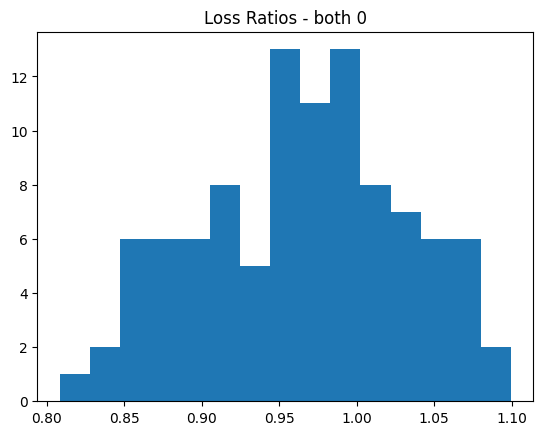

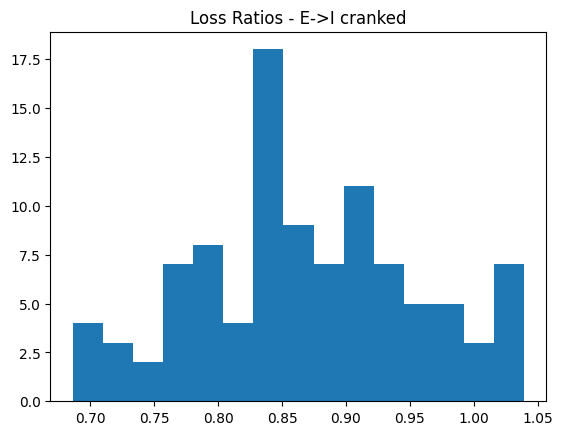

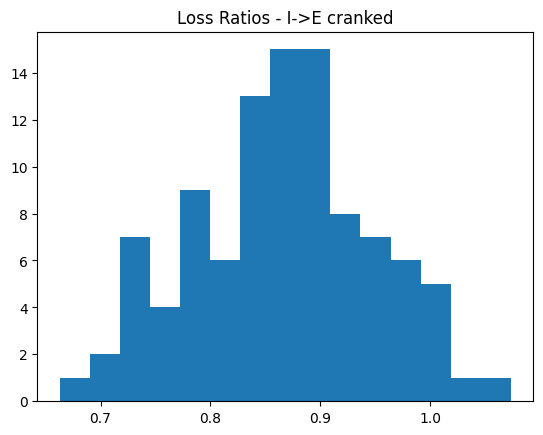

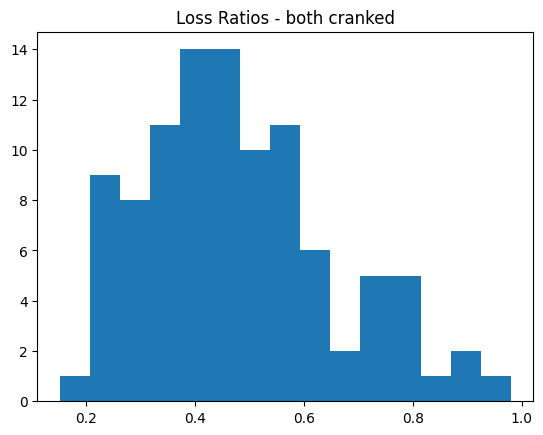

In [26]:
# Both zero
test_regime(0., 0.)
plt.title("Loss Ratios - both 0")
plt.show()
# IE cranked
test_regime(ie_max_weight, w_ei)
plt.title("Loss Ratios - E->I cranked")
plt.show()
# EI cranked
test_regime(w_ie, ei_min_weight)
plt.title("Loss Ratios - I->E cranked")
plt.show()
# Both cranked
test_regime(ie_max_weight, ei_min_weight)
plt.title("Loss Ratios - both cranked")
plt.show()

In [27]:
# Number of independent "sniffs" of the 16 odors
n_inner = 10
# Number of different realizations of the odor sniffing process
n_outer = 1000

# TODO change back to -3 if too noisy
plasticity_rate = 1e-1
# Same plasticity rate for EI and IE
plasticity_ie = plasticity_ei = plasticity_rate

# TODO experiment w/ diff gradient tracking numbers
# Number of inner epochs between model updates, n_update <= n_inner
n_update = 10
# Number of inner epochs across which the gradient is tracked (right now we detach the gradient after each inner epoch), n_track <= n_inner
n_track = n_update

# n_track = n_update to test formulation where we track the gradient across a subset of the inner epochs and update the model
# If n_update > n_track, the model will have multiple "gradient" paths of loss accumulated: ex. inner epochs 1-5 and a separate branch of 6-10
# If n_update < n_track, it doesn't matter b/c the model will truncate the history past its previous update since the gradient is zeroed

# Number of standard deviations from mean, we are trying 0 b/c 1 and 2 is too sparse
threshold_multiplier = 0

# TODO for now go to simple formulation, no weight decay
weight_decay = 0
# How much to weight each of the regularization terms
# Sparsity = 1000 doesn't improve loss ratios
# Sparsity = 100, 500 epochs, loss ratios 1.0-1.8, blows up sparsity
# Go back to 500 epochs no sparsity reg, w/ new nan clipping formulation
lambda_corr, lambda_mu, lambda_var, lambda_sp = 1, 0, 0, 0

ie_model = create_model()
ie_model.to(gpu)
ei_model = create_model()
ei_model.to(gpu)


mult = 100
w_ie = 0.5
ie_max_weight = mult * w_ie
ie_min_weight = 0

w_ei = -0.2
ei_max_weight = 0
ei_min_weight = mult * w_ei

ie_post = (num_e, num_neurons)
ie_pre = (0, num_e)

ei_post = (0, num_e)
ei_pre = (num_e, num_neurons)

def train_model():
    #torch.autograd.set_detect_anomaly(True)
    
    # TODO try LR -3
    # TODO try w/o momentum
    ie_optim = optim.SGD(ie_model.parameters(), lr=1e-3, momentum=0)
    ei_optim = optim.SGD(ei_model.parameters(), lr=1e-3, momentum=0)
    
    updates_per_outer = n_inner // n_update
    num_losses = int(updates_per_outer * n_outer)
    losses = torch.empty(size=(num_losses,))
    # batch every 20 (ex. tried 50 and was slightly more noisy (but w/ similar mean))
    # batch_every = 20
    # batch_loss = 0
    
    for outer_e in range(n_outer):
        i = correlated_mitral_activity()
        hbar_ff = compute_feedforward_activity(i)
        
        W_initial = compute_initial_recurrent_weights()
        W = W_initial.clone().to(gpu)
        W.requires_grad_(True)
        
        with torch.no_grad():
            ie_update_inds = get_update_inds(ie_post, ie_pre, W)
            ei_update_inds = get_update_inds(ei_post, ei_pre, W)
            
            clamp_min = torch.zeros_like(W)
            clamp_min[ei_update_inds] = ei_min_weight
            clamp_min[ie_update_inds] = ie_min_weight
            clamp_max = torch.zeros_like(W)
            clamp_max[ie_update_inds] = ie_max_weight
            clamp_max[ei_update_inds] = ei_max_weight
            weight_range = (clamp_min, clamp_max)
        
        # Initial neuron responses
        R = compute_piriform_response(hbar_ff, W, threshold_multiplier)
        
        # TODO look at loss ratios when we set weights to 0 (so the responses converge to the feedforward input value)
        # Intuition: should do worse at decorrelation (or maybe nothing)
        # If it does do worse, then there's an error in how we compute losses, if it doesn't do anything, the loss is being computed correctly
        # Check intuition of cranking up E->I and I->E to max value (for the update inds) and see what losses are like
        # - First only increase E to I, then only I to E, then both
        for i in range(1, n_inner + 1):
            with_loss = False
            detach_grad = False
            if i % n_update == 0:
                with_loss = True
                print(f"Outer epoch {outer_e}, Inner epoch {i}, Loss: \t", end="")
            if i % n_track == 0:
                detach_grad = True
            
            loss, overload, W, R = loss_after_odors(ie_model, ei_model, ie_update_inds, ei_update_inds, W, R, hbar_ff, threshold_multiplier, plasticity_ie, plasticity_ei, weight_decay, weight_range, lambda_corr, lambda_mu, lambda_var, lambda_sp, detach_grad=detach_grad, with_loss=with_loss)
            
            if with_loss:
                final_loss = loss

                R_initial = compute_piriform_response(hbar_ff, W_initial, threshold_multiplier)
                initial_loss = loss_fn(R_initial, lambda_corr, lambda_mu, lambda_var, lambda_sp, do_print=False)
                total_loss = final_loss / initial_loss
                #total_loss += overload
                print(f"Loss ratio: {total_loss}")
                losses[(outer_e * updates_per_outer)  + (i // n_update) - 1] = total_loss.item()
                total_loss.backward()
                #batch_loss += total_loss
                # ie_grad = torch.nn.utils.clip_grad_norm_(ie_model.parameters(), max_norm = 1e5)
                # ei_grad = torch.nn.utils.clip_grad_norm_(ei_model.parameters(), max_norm = 1e5)
                # print(f"ie model grad: {ie_grad}")
                # print(f"ei model grad: {ei_grad}")
                ie_optim.step()  
                ei_optim.step()
                ie_optim.zero_grad()
                ei_optim.zero_grad()
            
        # if outer_e % batch_every == 0:
        #     batch_loss.backward()   
        #     ie_optim.step()
        #     ei_optim.step()
        #     ie_optim.zero_grad()
        #     ei_optim.zero_grad()
        #     batch_loss = 0
                
    return losses

In [28]:
losses = train_model()

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.07 GiB. GPU 0 has a total capacity of 11.76 GiB of which 101.88 MiB is free. Process 67292 has 6.81 GiB memory in use. Including non-PyTorch memory, this process has 4.77 GiB memory in use. Of the allocated memory 3.80 GiB is allocated by PyTorch, and 861.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

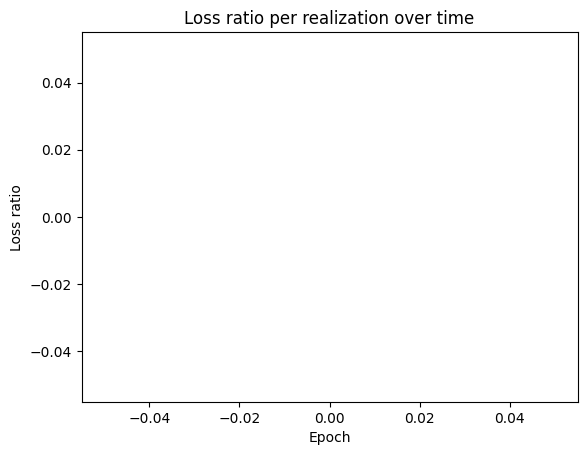

In [ ]:
with torch.no_grad():
    plt.plot(torch.arange(losses.shape[0]), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss ratio")
    plt.title("Loss ratio per realization over time")
    plt.show()

In [ ]:
i = correlated_mitral_activity()
hbar_ff = compute_feedforward_activity(i)
W_random = compute_initial_recurrent_weights()
R_random = compute_piriform_response(hbar_ff, W_random, threshold_multiplier)

In [ ]:
# Stats at initialization
mu_familiar_0 = torch.mean(R_random[:num_e, familiar_inds], dim=1)
sig_familiar_0 = torch.var(R_random[:num_e, familiar_inds], dim=1)
mu_novel_0 = torch.mean(R_random[:num_e, novel_inds], dim=1)
sig_novel_0 = torch.var(R_random[:num_e, novel_inds], dim=1)
#print(f"Initialization: \nFamiliar -  mean: {mu_familiar_0}, var: {sig_familiar_0}\nNovel -  mean: {mu_novel_0}, var: {sig_novel_0}")

In [ ]:
R_random = R_random.to(gpu)

In [ ]:
W_plastic = W_random.detach().clone()
R_plastic = R_random.detach().clone()
with torch.no_grad():
    ie_update_inds = get_update_inds(ie_post, ie_pre, W_plastic)
    ei_update_inds = get_update_inds(ei_post, ei_pre, W_plastic)
    clamp_min = torch.zeros_like(W_plastic)
    clamp_min[ei_update_inds] = ei_min_weight
    clamp_min[ie_update_inds] = ie_min_weight
    clamp_max = torch.zeros_like(W_plastic)
    clamp_max[ie_update_inds] = ie_max_weight
    clamp_max[ei_update_inds] = ei_max_weight
    weight_range = (clamp_min, clamp_max)


# Number of weights from each group to track
num_samples = 100
W_tracked = torch.empty((n_inner, num_samples, 2))
R_tracked = torch.empty((n_inner, num_i))
ie_track_inds = torch.randint(0, len(ie_update_inds), size=(num_samples,))
ei_track_inds = torch.randint(0, len(ei_update_inds), size=(num_samples,))
with torch.no_grad():
    for i in range(n_inner):
        _, W_plastic, R_plastic = loss_after_odors(ie_model, ei_model, ie_update_inds, ei_update_inds, W_plastic, R_plastic, hbar_ff, threshold_multiplier, plasticity_ie, plasticity_ei, weight_decay, weight_range, lambda_corr, lambda_mu, lambda_var, lambda_sp, detach_grad=True, with_loss=False)
        W_tracked[i, :, 0] = W_plastic[ie_update_inds][ie_track_inds].detach()
        W_tracked[i, :, 1] = W_plastic[ei_update_inds][ei_track_inds].detach()
        R_tracked[i, :] = torch.mean(R_plastic[num_e:, :], dim=1).detach()

mu_familiar_f = torch.mean(R_plastic[:num_e, familiar_inds], dim=1)
sig_familiar_f = torch.var(R_plastic[:num_e, familiar_inds], dim=1)
mu_novel_f = torch.mean(R_plastic[:num_e, novel_inds], dim=1)
sig_novel_f = torch.var(R_plastic[:num_e, novel_inds], dim=1)
mu_novel_diff = mu_novel_f - mu_novel_0
mu_familiar_diff = mu_familiar_f - mu_familiar_0
sig_novel_diff = sig_novel_f - sig_novel_0
sig_familiar_diff = sig_familiar_f - sig_familiar_0

ValueError: too many values to unpack (expected 3)

In [ ]:
R_random = R_random.cpu()
R_plastic = R_plastic.cpu()

In [ ]:
plt.plot(R_tracked)
plt.title("I responses across inner epochs")
plt.show()

In [ ]:
# Look at how weights evolve over the course of inner epoch, for a random realization
# Store a random set of 10 weights and see how the 10 weights change over the course of the iterations

In [ ]:
with torch.no_grad():
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.hist(torch.flatten(R_random[:num_e]), density=True, label="E responses")
    ax1.hist(torch.flatten(R_random[num_e:]), density=True, label="I responses")
    ax1.set_title("Before plasticity")
    ax1.legend()
    
    ax2.hist(torch.flatten(R_plastic[:num_e]), density=True, label="E responses")
    ax2.hist(torch.flatten(R_plastic[num_e:]), density=True, label="I responses")
    ax2.set_title("After plasticity")
    ax2.legend()
    fig.suptitle("Responses")
    plt.show()

In [ ]:
R_random[num_e:, :]

In [ ]:
# TODO figure out why I responses keep getting blown up to 0
R_plastic[num_e:, :]

In [ ]:
plt.hist(W_plastic[ei_update_inds].cpu().flatten())

In [ ]:
plt.hist(W_plastic[ie_update_inds].cpu().flatten())

In [ ]:
# TODO model is learning to set all E->I weights to 0, and that's causing I responses to go to 0, then I->E weights can't do anything to fix that
torch.unique((W_plastic[ie_update_inds].cpu().flatten()))

In [ ]:
with torch.no_grad():
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    sparsities_0 = sparsity_per_odor(R_random)
    spars_novel = sparsities_0[novel_inds]
    spars_familiar = sparsities_0[familiar_inds]
    ax1.hist(spars_novel, density=True, label="Novel")
    ax1.hist(spars_familiar, density=True, label="Familiar")
    ax1.set_title("Before plasticity")
    ax1.legend()
    
    sparsities_f = sparsity_per_odor(R_plastic)
    spars_novel = sparsities_f[novel_inds]
    spars_familiar = sparsities_f[familiar_inds]
    ax2.hist(spars_novel, density=True, label="Novel")
    ax2.hist(spars_familiar, density=True, label="Familiar")
    ax2.set_title("After plasticity")
    ax2.legend()
    fig.suptitle("Sparsity per odor")
    plt.show()

In [ ]:
def verification_set(ie_model, ei_model, runs=10):
    corrs = torch.empty((runs,))
    ratios = torch.empty((runs,))
    spars_change = torch.empty((runs,))
    for i in range(runs):
        I_ff = correlated_mitral_activity()
        hbar_ff = compute_feedforward_activity(I_ff)
        W_random = compute_initial_recurrent_weights()
        R_random = compute_piriform_response(hbar_ff, W_random, threshold_multiplier)
        _, initial_corr = odor_corrs(R_random)
        spars_initial = sparsity_per_odor(R_random)
        initial_spars_diff = torch.abs(torch.mean(spars_initial[novel_inds]) - torch.mean(spars_initial[familiar_inds]))
        
        ie_update_inds = get_update_inds(ie_post, ie_pre, W_random)
        ei_update_inds = get_update_inds(ei_post, ei_pre, W_random)
        
        for _ in range(n_inner):
            _, W_random, R_random = loss_after_odors(ie_model, ei_model, ie_update_inds, ei_update_inds, W_random, R_random, hbar_ff, threshold_multiplier, plasticity_ie, plasticity_ei, weight_decay, weight_range, lambda_corr, lambda_mu, lambda_var, lambda_sp, detach_grad=True, with_loss=False)
        
        _, final_corr = odor_corrs(R_random)
        ratio = final_corr / initial_corr
        spars_final = sparsity_per_odor(R_random)
        # Plot actual difference in the sparsity number, not the percent change ratio
        # - Also see whether 
        final_spars_diff = torch.abs(torch.mean(spars_final[novel_inds]) - torch.mean(spars_final[familiar_inds]))
        
        print(f"Corr: {initial_corr} -> {final_corr}, Sparsity: {initial_spars_diff} -> {final_spars_diff}, Loss Ratio: {ratio}")
        corrs[i] = final_corr.item()
        ratios[i] = ratio.item()
        spars_change[i] = (((final_spars_diff - initial_spars_diff) / initial_spars_diff) * 100).item()
        
    return corrs, ratios, spars_change

In [ ]:
with torch.no_grad():
    corrs, ratios, spars_change = verification_set(ie_model, ei_model, runs=10)

In [ ]:
plt.hist(ratios, bins=20)
plt.title("Loss ratios")
plt.show()
plt.hist(spars_change, bins=20)
plt.title("Percent change in sparsity per odor for novel vs. familiar families")
plt.show()

In [ ]:
spars_change[spars_change < 100]

In [ ]:
# version = "6"
# ie_path = f"./joint_models/ie_models/ie_model_{version}"
# torch.save(ie_model.state_dict(), ie_path)
# ei_path = f"./joint_models/ei_models/ei_model_{version}"
# torch.save(ei_model.state_dict(), ei_path)

# Model 2 - loss ratios between 0.75 and 1, most sparsity changes within 100%
# Model 3 - loss ratios between 0.94 and 1.04, reduces sparsity close to 100% (but has NaN values) 
# Model 4 - reduces sparsity close to 100%, loss ratios between 0.85 and 1 (basically tries to set weights to 0)
# Model 5 - loss ratios between 0.9 and 1.1, most sparsity changes go to 0 (negative 100% sparsity change)

# Interesting result from model 1 - tries to set all weights to 0
#ie_model = create_model()
#ie_model.load_state_dict(torch.load(ie_path))
#ei_model = create_model()
#ei_model.load_state_dict(torch.load(ei_path))

In [ ]:
def make_colormap(model, type="ie"):
    num_ticks = 100
    E_min, E_max = torch.min(R_plastic[:num_e, :]), torch.max(R_plastic[:num_e, :])
    I_min, I_max = torch.min(R_plastic[num_e:, :]), torch.max(R_plastic[num_e:, :])
    E_vals = torch.linspace(E_min, E_max, num_ticks)
    I_vals = torch.linspace(I_min, I_max, num_ticks)
    E_coords, I_coords = torch.meshgrid(E_vals, I_vals, indexing="ij")
    R_plot = 0
    if type == "ie":
        R_plot = torch.stack((E_coords.flatten(), I_coords.flatten()), dim=1)
    elif type == "ei":
        R_plot = torch.stack((I_coords.flatten(), E_coords.flatten()), dim=1)
    
    with torch.no_grad():
        plasticity_vals = model(R_plot.to(gpu)).squeeze(0).cpu()
        
    plot = plt.scatter(R_plot[:, 0], R_plot[:, 1], c=plasticity_vals, cmap='rainbow')
    clrbar = plt.colorbar(plot)
    clrbar.set_label('Model plasticity')
    plt.xlabel("E responses")
    plt.ylabel("I responses")
        
    return E_min, E_max, I_min, I_max, R_plot, plasticity_vals

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

def fit_model(model, type="ie", degree=3):
    E_min, E_max, I_min, I_max, R_plot, plasticity_vals = make_colormap(model, type)
    

    std = 2 # Take data within 2 std of responses mean
    mu_e = torch.mean(torch.flatten(R_plastic[:num_e].cpu()))
    sig_e = torch.std(torch.flatten(R_plastic[:num_e].cpu()))
    mu_i = torch.mean(torch.flatten(R_plastic[num_e:].cpu()))
    sig_i = torch.std(torch.flatten(R_plastic[num_e:].cpu()))
    e_train_bounds = (torch.max(E_min, mu_e - std*sig_e), torch.min(E_max, mu_e + std*sig_e))
    i_train_bounds = (torch.max(I_min, mu_i - std*sig_i), torch.min(I_max, mu_i + std*sig_i))
    
    reg = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('linear', LinearRegression(fit_intercept=False))])
    
    e_inds = torch.logical_and(torch.ge(R_plot[:, 0], e_train_bounds[0]), torch.le(R_plot[:, 0], e_train_bounds[1]))
    i_inds = torch.logical_and(torch.ge(R_plot[:, 1], i_train_bounds[0]), torch.le(R_plot[:, 1], i_train_bounds[1]))
    b = torch.logical_and(e_inds, i_inds)
    X = R_plot[b]
    y = plasticity_vals[b].squeeze(0)
    
    reg = reg.fit(X, y)
    # Exclude bias term
    coefs = reg.named_steps['linear'].coef_[0][1:]
    # How many terms to consider
    take = 3
    # Take largest magnitude terms
    inds = np.argsort(np.abs(coefs))[-take:]

    # Exclude bias term
    term_list = reg.named_steps['poly'].powers_[1:, :]
    terms = f"[Pre, Post] Powers:\n"
    for i in range(take - 1, -1, -1):
        term = f"{term_list[inds][i]}: {coefs[inds][i]}\n"
        terms += term
    
    print(terms)
    
    preds = reg.predict(X).ravel()
    return X, preds

In [ ]:
ie_X, ie_preds = fit_model(ie_model, type="ie", degree=3)

pred_plot = plt.scatter(ie_X[:, 0], ie_X[:, 1], c=ie_preds, cmap='rainbow')
clrbar2 = plt.colorbar(pred_plot)
clrbar2.set_label('Predicted')
plt.title("E-I plasticity based on neural responses")
plt.xlabel("E responses")
plt.ylabel("I responses")
plt.show()

ei_X, ei_preds = fit_model(ei_model, type="ei", degree=3)

pred_plot = plt.scatter(ei_X[:, 0], ei_X[:, 1], c=ei_preds, cmap='rainbow')
clrbar2 = plt.colorbar(pred_plot)
clrbar2.set_label('Predicted')
plt.title("I-E plasticity based on neural responses")
plt.xlabel("I responses")
plt.ylabel("E responses")
plt.show()

In [ ]:
# Do a plot of rho_0 vs rho_final (for ex. 100 random initializations) to see whether the model can decorrelate odors
# Even though potentiation is always positive for the set of responses, since we are doing E to I, increasing the connection strength effectively increases inhibition too, so it balances out
# Not directly hebbian because that would mean there is some constant c*r_i*r_j, but when one of the responses is decreasing, the resulting potentiation doesn't decrease
# Instead, it will be an a * r_i + b * r_j term
# These terms come from the polynomial expansion of the function defined by the model

In [ ]:
# Look at statistics of E neurons (mean firing rate across odors, variance, etc) at initialization compared to after plasticity
# Also look at sparsity - one across odors and another across neurons (sparsity is essentially 1 minus the square of the coefficient of variation)
# We care mostly about the sparsity across neurons (ex between neurons) and what it would be between odors (should be similar between the familiar odors b/c that's where we applied the plasticity) and we also know what it's like between novel odors
# We don't want a change in firing rate, because it should be same for novel and familiar odors

In [ ]:
with torch.no_grad():
    pct_change = ((W_tracked[:, :, 0] - w_ie) / w_ie) * 100
    plt.plot(pct_change)
    plt.xlabel("Inner epochs")
    plt.ylabel("Weight percent change")
    plt.title("E-I weight change")
    plt.show()
    
    pct_change = ((W_tracked[:, :, 1] - w_ei) / w_ei) * 100
    plt.plot(pct_change)
    plt.xlabel("Inner epochs")
    plt.ylabel("Weight percent change")
    plt.title("I-E weight change")
    plt.show()

In [ ]:
W_change = ((W_plastic[ie_update_inds].cpu() - w_ie) / w_ie) * 100
plt.hist(W_change, density=True, bins=50)
plt.title("E-I Percent weight change from initialization")
plt.show()

W_change = ((W_plastic[ei_update_inds].cpu() - w_ei) / w_ei) * 100
plt.hist(W_change, density=True, bins=50)
plt.title("I-E Percent weight change from initialization")
plt.show()

In [ ]:
plt.hist(mu_familiar_0.detach().cpu() - mu_novel_0.detach().cpu(), bins=50, label="Before")
plt.hist(mu_familiar_f.detach().cpu() - mu_novel_f.detach().cpu(), bins=50, label="After")
plt.legend()
plt.show()

In [ ]:
plt.hist(mu_novel_diff, bins=50, label="Novel")
plt.hist(mu_familiar_diff, bins=50, label="Familiar")
plt.title("Difference in mean responses before and after plasticity")
plt.legend()
plt.show()

In [ ]:
sp_novel_0 = sparsity_per_neuron(R_random, novel_inds)
sp_novel_f = sparsity_per_neuron(R_plastic, novel_inds)
sp_familiar_0 = sparsity_per_neuron(R_random, familiar_inds)
sp_familiar_f = sparsity_per_neuron(R_plastic, familiar_inds)

In [ ]:
with torch.no_grad():
    plt.hist(sp_novel_0, cumulative=True, bins=num_e, histtype="step", label="Novel_0")
    plt.hist(sp_familiar_0, cumulative=True, bins=num_e, histtype="step", label="Familiar_0")
    plt.hist(sp_novel_f, cumulative=True, bins=num_e, histtype="step", label="Novel_f")
    plt.hist(sp_familiar_f, cumulative=True, bins=num_e, histtype="step", label="Familiar_f")
    plt.legend()
    plt.show()

In [ ]:
# Create scatter plot of odor correlation vs sparsity difference - odors that are highly positively correlated should have similar sparsities across neurons, and those that are highly negatively correlated should have different sparsities across neurons
# Check - increase P' all the way to 16, and with lower correlations, there should be less variability between the sparsity for each odor
# - would tell us how much the natural spread in sparsity is

In [ ]:
# 1. Re-run model w/ lower threshold (0 stdev above mean)
# 2. Figure out percentage-wise how much the weights actually change (do a hist)
# - if it's 1-2% it's too small, we want the weights to change 10-100%, the weights could even change 10-fold
# 3. Add metrics to training function - automatically compute sparsity etc (also look at the sparsity between odors, not just the sparsity between neurons, see if it changes for novel vs familiar)
# Create bar plot for each number of odors, how many neurons respond to that number of odors (ideally, if we have a threshold of 0 stdev, most neurons should respond to ~4 odors, since on average a neuron will respond to half of the total odors, so 8 odors, and out of those, it should be equal between 4 novel and 4 familiar)
# Hypothesis right now - weights aren't changing that much, so we can add more epoch_inner steps (since the gradient isn't blowing up)
# Then, try removing plasticity ramp - keep 1e-3 (don't do epoch_inner increase and remove plasticity ramp at same time)
# Goal: understand what mechanism the meta-learning discovered that makes correlations smaller (see whether it acts on sparsity etc)
# Think of other metrics to quantify network behavior to understand change